# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
%matplotlib inline

import cv2
import glob
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import pickle
import tensorflow as tf
import time

from datetime import timedelta
from scipy.stats import describe
from skimage import img_as_ubyte
from skimage.color import rgb2gray
from skimage.exposure import rescale_intensity, equalize_hist, equalize_adapthist
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from tqdm import tqdm
from tensorflow.contrib.layers import fully_connected

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)

In [2]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = './datasets/lab_2_data/train.p'
testing_file = './datasets/lab_2_data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = [X_train.shape[1], X_train.shape[2], X_train.shape[3]]

# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = [32, 32, 3]
Number of classes = 43


Skew : 0.635681


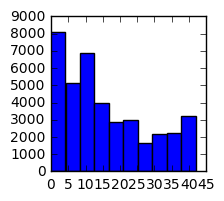

In [4]:
plt.rcParams["figure.figsize"] = (2,2)
print("Skew : {0:8.6f}".format(describe(y_train).skewness))
plt.hist(y_train)
plt.show()

In [5]:
number_of_examples = []
for label in range(43):
    number_of_examples.append(sum(y_train == label))

max(number_of_examples)

2250

In [6]:
# Credits to Vivek Yadav
def transform_image(img, ang_range, shear_range, trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

In [7]:
number_needed = max(number_of_examples)
for label in range(43):
    number = number_of_examples[label]
    if number_needed > number:
        for j in np.random.choice(np.where(y_train == label)[0], number_needed - number):
            img = transform_image(X_train[j],10,5,1)            
            X_train = np.append(X_train, [img], axis=0)
            y_train = np.append(y_train, label)

Skew : 0.000000


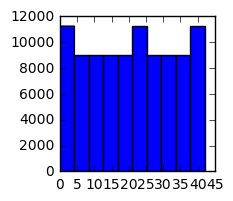

In [8]:
plt.rcParams["figure.figsize"] = (2,2)
print("Skew : {0:8.6f}".format(describe(y_train).skewness))
plt.hist(y_train)
plt.show()

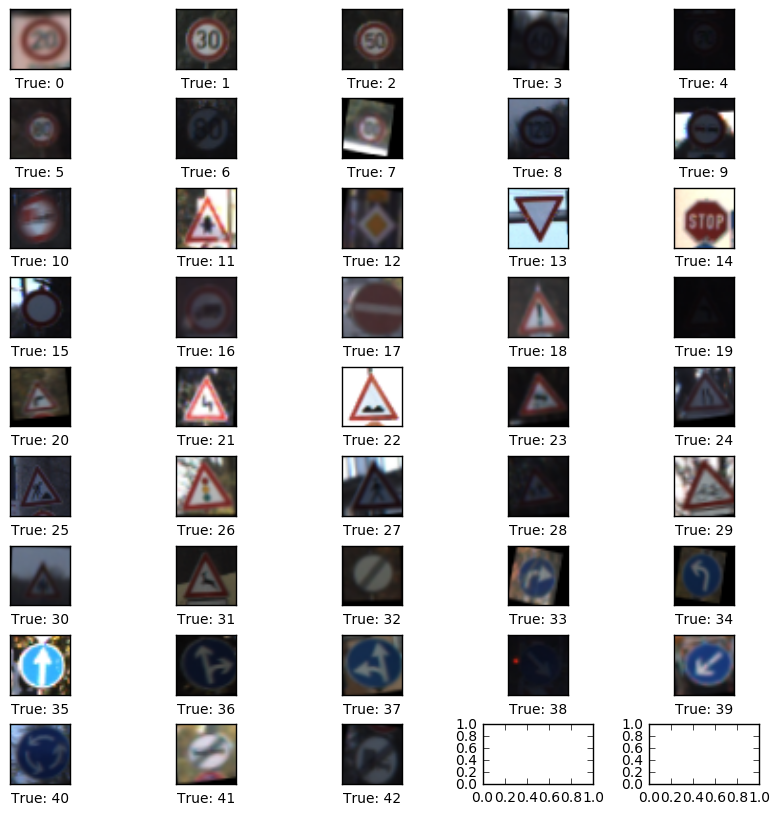

In [9]:
plt.rcParams["figure.figsize"] = (10,10)
fig, axes = plt.subplots(9, 5)
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for label, ax in enumerate(axes.flat):
    if label >= 43: 
        break
    # Plot image.
    for i in np.random.choice(np.where(y_train == label)[0], 1):    
        ax.imshow(X_train[i], cmap='binary')
        ax.set_xlabel("True: {0}".format(label))
        ax.set_xticks([])
        ax.set_yticks([])
plt.show()

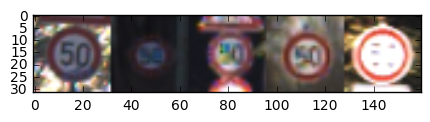

In [10]:
plt.rcParams["figure.figsize"] = (5,5)
label = 2
images = np.array([])
for i in np.random.choice(np.where(y_train == label)[0], 5):    
    if images.size == 0:
        images = X_train[i]
    else:
        images = np.hstack((images,X_train[i]))
plt.imshow(images)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 1 

_Describe the techniques used to preprocess the data._

In [11]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

**Answer:**

Original dataset is very unbalanced so I created additional jittered images so every class of images had the same number of images.
All three channels of the images look redundant. So I converted images to gray. I also used `skimage` package to stretch out intensity and make images more contrast.

/Users/Bombard/anaconda/envs/udacity/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


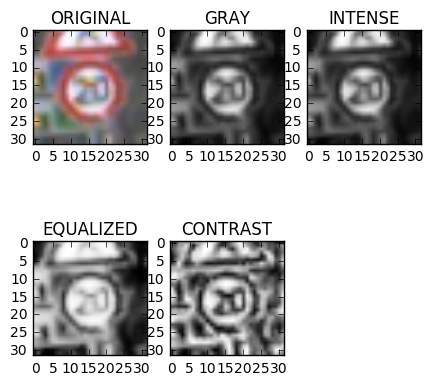

In [12]:
gray_image      = rgb2gray(X_train[0])
intense_image   = rescale_intensity(gray_image)
equalized_image = equalize_hist(intense_image)
contrast_image  = equalize_adapthist(equalized_image)

plt.subplot(231),plt.imshow(X_train[0],'gray'),plt.title('ORIGINAL')
plt.subplot(232),plt.imshow(gray_image,'gray'),plt.title('GRAY')
plt.subplot(233),plt.imshow(intense_image,'gray'),plt.title('INTENSE')
plt.subplot(234),plt.imshow(equalized_image,'gray'),plt.title('EQUALIZED')
plt.subplot(235),plt.imshow(contrast_image,'gray'),plt.title('CONTRAST')
plt.show()

In [13]:
# lets put the preprocessing algorithm into the function to apply to every image in the training set
def preprocess(orig_image):
    image = rgb2gray(orig_image)
    image = rescale_intensity(image)
    image = equalize_hist(image)
    image = equalize_adapthist(image)
    return image

In [14]:
features = np.array(list(map(lambda x: preprocess(x), X_train)))

/Users/Bombard/anaconda/envs/udacity/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


/Users/Bombard/anaconda/envs/udacity/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()


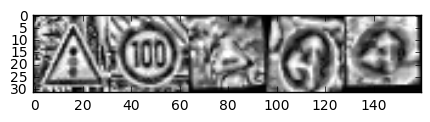

In [15]:
images = None
for i in np.random.choice(range(len(features)), 5):    
    if images == None:
        images = features[i]
    else:
        images = np.hstack((images, features[i]))
plt.imshow(images, cmap='gray')
plt.show()

In [16]:
test_features = np.array(list(map(lambda x: preprocess(x), X_test)))

/Users/Bombard/anaconda/envs/udacity/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


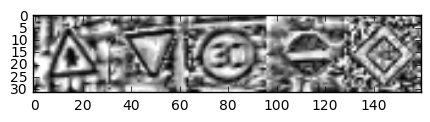

In [17]:
images = np.array([])
for i in np.random.choice(range(len(test_features)), 5):    
    if images.size == 0:
        images = test_features[i]
    else:
        images = np.hstack((images, test_features[i]))
plt.imshow(images, cmap='gray')
plt.show()

Labels should be converted from integer label of the class to array with all `0` and `1` for index, representing the class of the picture

In [18]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
encoder.fit(y_train)
labels = encoder.transform(y_train)
test_labels = encoder.transform(y_test)

Images in the training set are sorted by the class, it means images of the same class will be grouped together in a batch during training, it would hurt the performance of the model, so I will shuffle the training set.

In [19]:
features, labels = shuffle(features, labels)

In [20]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
from sklearn.model_selection import train_test_split
train_features, valid_features, train_labels, valid_labels = train_test_split(features, labels, test_size=0.33, random_state=1)

In [21]:
print(train_features.shape)
print(valid_features.shape)

(64822, 32, 32)
(31928, 32, 32)


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

I split training set into training and validation sets, usign 33% of training data as validation data, to train model and validate the accuracy on unseen data to chose parameters of my network.
Such validation would make the model overfit the validation set so I kept test set to get true error, after parameters were chosen.

In [22]:
# This parameters gave over 90% accuracy

# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128 

# Image size
img_size = 32

# Number of channels of the image: 1 channel for gray-scale.
num_channels = 1

# Size of flattened image.
img_size_flat = img_size * img_size * num_channels

# Image shape
img_shape = (img_size, img_size)

# Number of classes
num_classes = n_classes

# Size of train batch
train_batch_size = 64

# Size of test batch
test_batch_size = 256

In [23]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [24]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [25]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    layer = tf.nn.relu(layer)

    return layer, weights

In [26]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    layer_flat = tf.reshape(layer, [-1, num_features])

    return layer_flat, num_features

In [27]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** While researching other results in this area I found the article about [Multi-Column Deep Neural Network for Traffic Sign
Classification](http://people.idsia.ch/~juergen/nn2012traffic.pdf). I've started from one convolution layer and was increasing the complexity of the model into direction of the model in the article. The final architecture of the network is 2 convolutional 5x5 layers with depth 16 and 36, each is followed by max-pooling and RELU layers; second convolutional layer is followed by flatten layer and two fully connected layers of size of 128 neurons each. The result of the last layer is processed by softmax function to normalize probabilities of the classes.

In [28]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x

<tf.Tensor 'x:0' shape=(?, 1024) dtype=float32>

In [29]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 16, 16, 16) dtype=float32>

In [30]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 8, 8, 36) dtype=float32>

In [31]:
layer_flat, num_features = flatten_layer(layer_conv2)
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 2304) dtype=float32>

In [32]:
num_features

2304

In [33]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [34]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 43) dtype=float32>

In [35]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [36]:
session = tf.Session()
session.run(tf.initialize_all_variables())

In [37]:
def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations
    
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations, total_iterations + num_iterations):
        start = (total_iterations + i) * train_batch_size 
        if start > data_train_images.shape[0]:
            return
        
        end = min((total_iterations + i + 1) * train_batch_size, data_train_images.shape[0])
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch      = data_train_images[start:end].reshape(-1, img_size_flat)
        y_true_batch = data_train_labels[start:end]
    
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}, start: {2:>6}, end: {3:>6}"

            # Print it.
            print(msg.format(i + 1, acc, start, end))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [38]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data_test_images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data_test_labels[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=np.argmax(cls_true,1)[0:9],
                cls_pred=cls_pred[0:9])

In [39]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data_test_labels
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=np.argmax(cls_true,1),
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [40]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data_test_images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data_test_images[i:j, :]

        # Get the associated labels.
        labels = data_test_labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = np.argmax(data_test_labels, 1)

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = np.array(correct).sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)
    

In [41]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** 

Training model on the training set for 20 epoches, using [Adam Optimizer](https://www.tensorflow.org/versions/r0.11/api_docs/python/train.html#AdamOptimizer) with learning rate of `1e-4` and batch size of 64 examples. I set number of iterations big enough to ensure that the model will use all training examples during one epoche of training (batch size * number of iterations >= size of training set)

In [42]:
data_train_images = train_features.reshape(-1, img_size_flat)
data_train_labels = train_labels
for e in range(20):
    total_iterations = 0
    optimize(num_iterations=2000)

Optimization Iteration:      1, Training Accuracy:   1.6%, start:      0, end:     64
Optimization Iteration:    101, Training Accuracy:   1.6%, start:   6400, end:   6464
Optimization Iteration:    201, Training Accuracy:   4.7%, start:  12800, end:  12864
Optimization Iteration:    301, Training Accuracy:  21.9%, start:  19200, end:  19264
Optimization Iteration:    401, Training Accuracy:  21.9%, start:  25600, end:  25664
Optimization Iteration:    501, Training Accuracy:  26.6%, start:  32000, end:  32064
Optimization Iteration:    601, Training Accuracy:  45.3%, start:  38400, end:  38464
Optimization Iteration:    701, Training Accuracy:  51.6%, start:  44800, end:  44864
Optimization Iteration:    801, Training Accuracy:  48.4%, start:  51200, end:  51264
Optimization Iteration:    901, Training Accuracy:  51.6%, start:  57600, end:  57664
Optimization Iteration:   1001, Training Accuracy:  43.8%, start:  64000, end:  64064
Optimization Iteration:      1, Training Accuracy:  48

Accuracy on Test-Set: 95.6% (30512 / 31928)
Example errors:


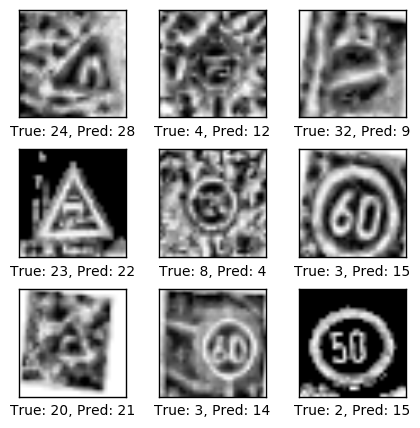

Confusion Matrix:
[[710   0   0 ...,   8   0   0]
 [  3 629  20 ...,   7   0   0]
 [  0   4 688 ...,   0   0   0]
 ..., 
 [  0   0   0 ..., 727   0   0]
 [  0   0   0 ...,   1 673   2]
 [  0   0   0 ...,   2   5 692]]


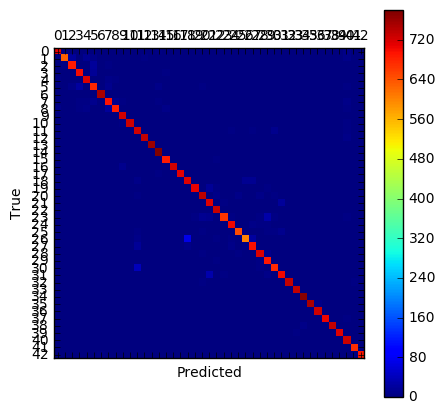

In [43]:
plt.rcParams["figure.figsize"] = (5,5)
data_test_images = valid_features.reshape(-1, img_size_flat)
data_test_labels = valid_labels
print_test_accuracy(True, True)

After parameters were chosen the model can be trained on all training data and true error can be get by testing the model on testing data

In [44]:
data_train_images = features.reshape(-1, img_size_flat)
data_train_labels = labels
for e in range(40):
    total_iterations = 0
    optimize(num_iterations=2000)

Optimization Iteration:      1, Training Accuracy:  96.9%, start:      0, end:     64
Optimization Iteration:    101, Training Accuracy:  96.9%, start:   6400, end:   6464
Optimization Iteration:    201, Training Accuracy:  93.8%, start:  12800, end:  12864
Optimization Iteration:    301, Training Accuracy:  98.4%, start:  19200, end:  19264
Optimization Iteration:    401, Training Accuracy: 100.0%, start:  25600, end:  25664
Optimization Iteration:    501, Training Accuracy: 100.0%, start:  32000, end:  32064
Optimization Iteration:    601, Training Accuracy:  98.4%, start:  38400, end:  38464
Optimization Iteration:    701, Training Accuracy:  98.4%, start:  44800, end:  44864
Optimization Iteration:    801, Training Accuracy:  95.3%, start:  51200, end:  51264
Optimization Iteration:    901, Training Accuracy: 100.0%, start:  57600, end:  57664
Optimization Iteration:   1001, Training Accuracy:  98.4%, start:  64000, end:  64064
Optimization Iteration:   1101, Training Accuracy:  98

Accuracy on Test-Set: 94.2% (11895 / 12630)
Example errors:


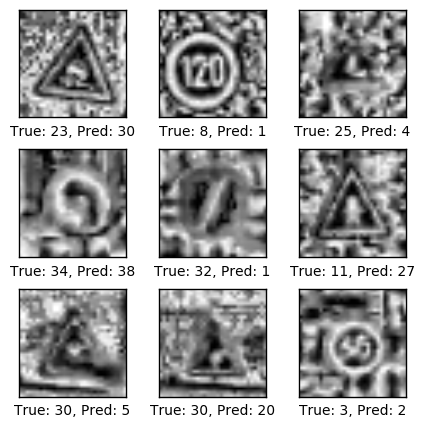

Confusion Matrix:
[[ 50   8   0 ...,   0   0   0]
 [  6 694  12 ...,   0   0   0]
 [  0  10 726 ...,   0   0   0]
 ..., 
 [  2   0   0 ...,  81   0   0]
 [  0   0   0 ...,   0  60   0]
 [  0   0   0 ...,   1   1  78]]


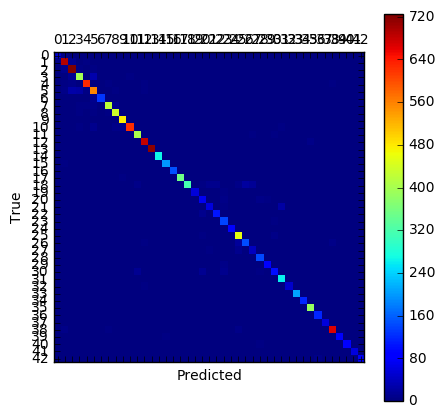

In [45]:
plt.rcParams["figure.figsize"] = (5,5)
data_test_images = test_features.reshape(-1, img_size_flat)
data_test_labels = test_labels
print_test_accuracy(True, True)

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:** I was usign different hyperparameters and validate the model on separate validation set to avoid overfitting.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [46]:
files = glob.glob("./signs/*.jpg")
custom_images = []
custom_labels  = []
for filename in files:
    label = int(os.path.basename(filename).split("_")[0])
    custom_labels.append(label)
    custom_images.append(cv2.imread(filename,1))

In [47]:
custom_images = np.array(custom_images)
custom_images.shape

(29, 32, 32, 3)

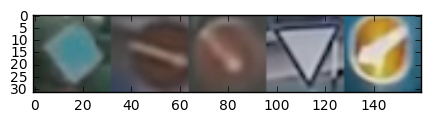

In [48]:
images = np.array([])
for i in np.random.choice(range(len(custom_images)), 5):    
    if images.size == 0:
        images = custom_images[i]
    else:
        images = np.hstack((images, custom_images[i]))
plt.imshow(images)
plt.show()

In [49]:
custom_images = np.array(list(map(lambda x: preprocess(x), custom_images)))

/Users/Bombard/anaconda/envs/udacity/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


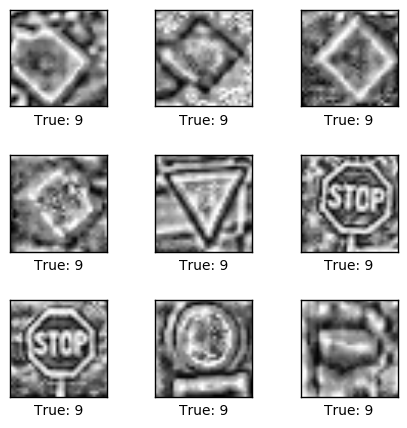

In [50]:
plt.rcParams["figure.figsize"] = (5,5)
fig, axes = plt.subplots(3, 3)
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, ax in enumerate(axes.flat):
    ax.imshow(custom_images[i], cmap='gray')
    ax.set_xlabel("True: {0}".format(label))
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [51]:
custom_labels = encoder.transform(custom_labels)
custom_labels.shape

(29, 43)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

Bad quality of photos hurts the performance of the model. It also seems model uses not optimal features for some classes - last two picture in example errors are easily recognized. 

Accuracy on Test-Set: 62.1% (18 / 29)
Example errors:


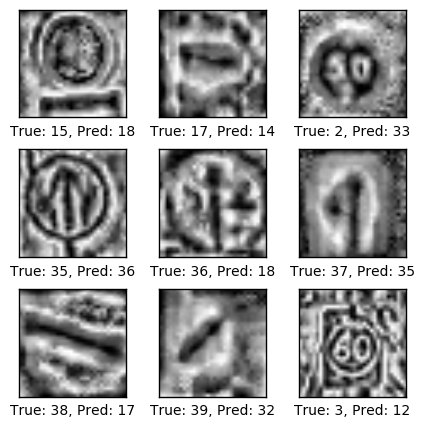

Confusion Matrix:
[[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


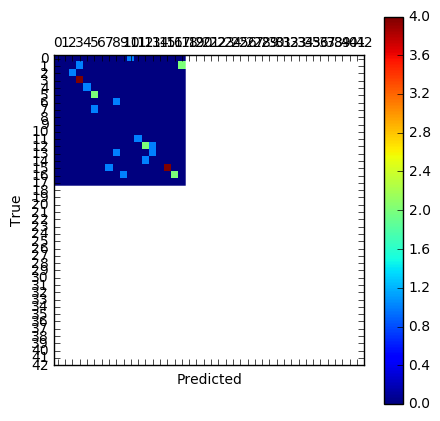

In [52]:
plt.rcParams["figure.figsize"] = (5,5)
data_test_images = custom_images.reshape(-1, img_size_flat)
data_test_labels = custom_labels
print_test_accuracy(True, True)

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:** the model performs better on testing datasets but partially it can be caused by bad quality of some captured pictures.

In [53]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
in_top_5    = tf.nn.in_top_k(y_pred, np.argmax(custom_labels,1), 5)
feed_dict   = {x: custom_images.reshape(-1, img_size_flat), y_true: custom_labels}
predictions = session.run(correct_prediction, feed_dict=feed_dict)
neighbours  = session.run(in_top_5, feed_dict=feed_dict)

In [54]:
sum(neighbours)/len(neighbours)

0.86206896551724133

In [55]:
for i in range(len(predictions)):
    if not predictions[i] and not neighbours[i]:
        print('Index {}: both model and knn gave incorrect prediction'.format(i))
    elif not predictions[i]:
        print('Index {}: model gave incorrect prediction'.format(i))
    elif not neighbours[i]:
        print('Index {}: knn gave incorrect prediction'.format(i))

Index 7: both model and knn gave incorrect prediction
Index 8: model gave incorrect prediction
Index 9: both model and knn gave incorrect prediction
Index 11: model gave incorrect prediction
Index 15: model gave incorrect prediction
Index 16: model gave incorrect prediction
Index 18: model gave incorrect prediction
Index 22: model gave incorrect prediction
Index 25: both model and knn gave incorrect prediction
Index 26: model gave incorrect prediction
Index 27: both model and knn gave incorrect prediction


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:** from 29 examples, knn predicted 6 images more correctly. It also predicted correctly all examples the model predicted correctly.

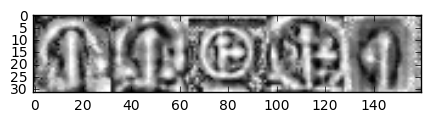

In [56]:
images = np.array([])
for i in range(5):
    image = custom_images[12:17][i] 
    if images.size == 0:
        images = image
    else:
        images = np.hstack((images, image))
plt.imshow(images, cmap='gray')
plt.show()  

In [57]:
feed_dict = {x: custom_images[12:17].reshape(-1, img_size_flat)}
softmax   = session.run(y_pred, feed_dict=feed_dict)

In [58]:
softmax[0]

array([  0.00000000e+00,   5.43296729e-34,   0.00000000e+00,
         3.66969678e-35,   2.04455654e-38,   3.22761068e-32,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         6.08627984e-35,   2.38072389e-34,   2.24496624e-23,
         7.44467881e-26,   3.26370563e-22,   0.00000000e+00,
         1.94052277e-31,   0.00000000e+00,   0.00000000e+00,
         9.39430637e-20,   8.73285662e-31,   2.71044318e-26,
         1.84811498e-26,   1.07474420e-33,   1.00253195e-34,
         9.26978315e-35,   1.38126567e-29,   2.27024770e-26,
         8.39371292e-34,   1.10956488e-29,   1.17870826e-37,
         5.56538308e-30,   0.00000000e+00,   0.00000000e+00,
         1.87762031e-14,   2.64567098e-23,   9.99997854e-01,
         2.19145022e-06,   3.76415751e-17,   3.16803702e-30,
         6.22792978e-34,   4.17990970e-27,   0.00000000e+00,
         9.57089911e-35], dtype=float32)

In [59]:
np.argmax(softmax, axis=1)

array([35, 35, 36, 18, 35])

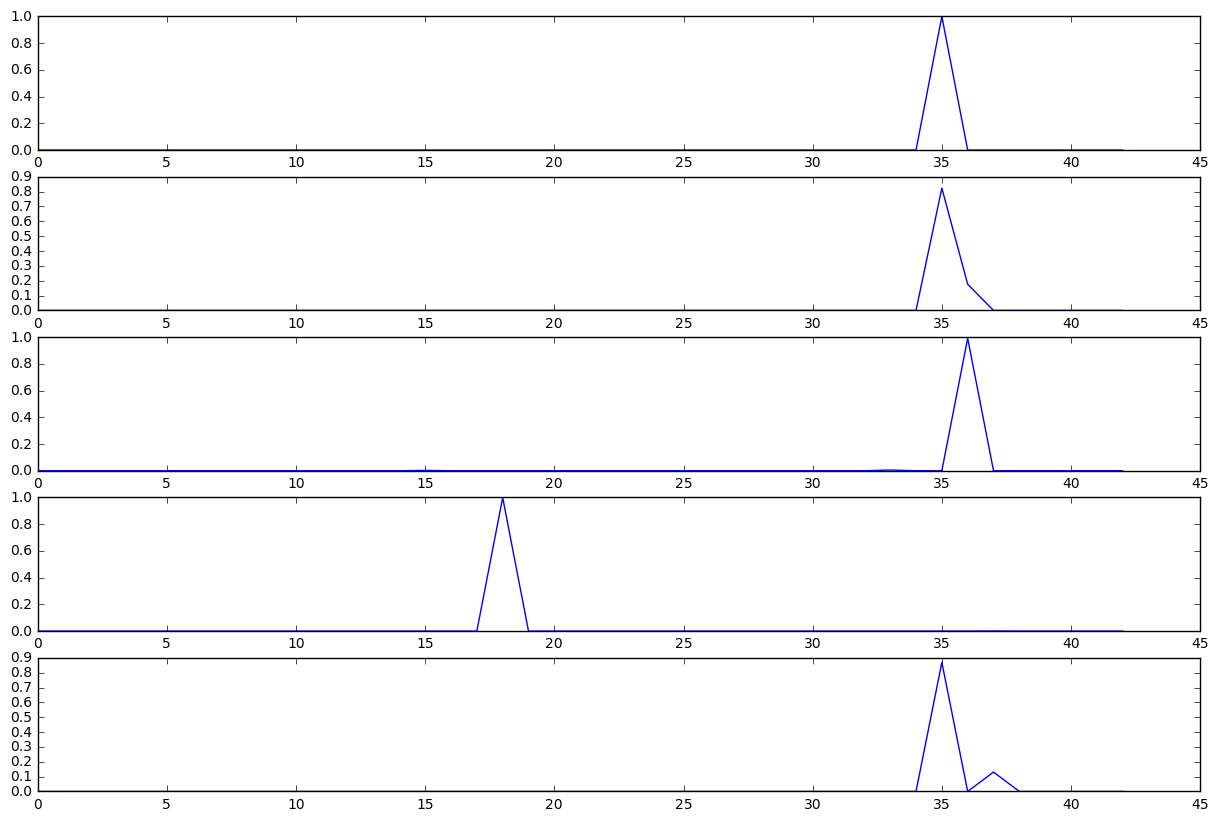

In [60]:
plt.rcParams["figure.figsize"] = (15,10)
from matplotlib import gridspec

fig = plt.figure()
gs = gridspec.GridSpec(5, 1)
for i in range(5):
    sp = fig.add_subplot(gs[i,0])
    sp.plot(range(43), softmax[i])

In [71]:
# print classes and values for 5 largest probabilities for chosen images
for i in range(5):
    print(softmax[i].argsort()[-5:][::-1])
    print(heapq.nlargest(5,softmax[i]))

[35 36 33 37 18]
[0.99999785, 2.1914502e-06, 1.8776203e-14, 3.7641575e-17, 9.3943064e-20]
[35 36 33 18 37]
[0.82395869, 0.17604131, 4.7977837e-12, 4.0029143e-12, 3.1478559e-12]
[36 33 15 38 34]
[0.99149054, 0.005577852, 0.0027536766, 0.00017641278, 1.4040636e-06]
[18 37 35 36 28]
[0.99902892, 0.00097108894, 1.6142637e-08, 8.709454e-11, 8.8877211e-15]
[35 37 33 36 13]
[0.86946368, 0.13053633, 1.3778608e-08, 3.1943979e-11, 8.3220774e-12]


The model has small doubts for 2nd and 5th images, but overall is quite sure about the predicted class. The doubt can be explained by similarity between classes 35, 36 and 37 - all of them have the same central arrow.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:** new images should be preprocessed by `preprocess` function and new labels should be encoded. Predictions for new images may be acquired by following code:
```
session.run(y_pred_cls, feed_dict={x: x})
```
where `x` is a flat list of new images

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.